### Imports

In [10]:
import pandas as pd
import numpy as np
%matplotlib inline
import feather
import os
import statsmodels
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set(style="darkgrid")

### Read Data and Store as Feather File

In [ ]:
#df = pd.read_csv('./Historical_Data_ICM_25-Jul-2018.csv', parse_dates=['TIME_ID'])

In [ ]:
#feather.write_dataframe(df,'./Historical_Data.feather')

In [11]:
df = feather.read_dataframe('./Historical_Data.feather')

In [12]:
df.head()

,DSLAM_NAME,TIME_ID,TOTAL,USED,SPARE,FAULTY,EXCHANGE_NAME
0,NAAAAA,2017-04-01,192,143,49,0,MUSWELL HILL ...
1,NAAAAA,2017-04-08,192,143,49,0,MUSWELL HILL ...
2,NAAAAA,2017-04-15,192,142,50,0,MUSWELL HILL ...
3,NAAAAA,2017-04-22,192,144,48,0,MUSWELL HILL ...
4,NAAAAA,2017-04-29,192,145,47,0,MUSWELL HILL ...


In [13]:
df['TIME_ID'] = pd.to_datetime(df['TIME_ID'], infer_datetime_format=True)

In [14]:
df = df.set_index(['TIME_ID'])

In [15]:
df.head()

,DSLAM_NAME,TOTAL,USED,SPARE,FAULTY,EXCHANGE_NAME
TIME_ID,,,,,,
2017-04-01,NAAAAA,192,143,49,0,MUSWELL HILL ...
2017-04-08,NAAAAA,192,143,49,0,MUSWELL HILL ...
2017-04-15,NAAAAA,192,142,50,0,MUSWELL HILL ...
2017-04-22,NAAAAA,192,144,48,0,MUSWELL HILL ...
2017-04-29,NAAAAA,192,145,47,0,MUSWELL HILL ...


In [16]:
df_dslam = df['DSLAM_NAME'].unique().tolist()

In [17]:
len(df_dslam)

89965

### Functions to Get Dataframe Values for a Particular DSLAM and Plot It

In [18]:
def getDataframe(name):
    dataframe = df[df['DSLAM_NAME'] == name].copy()
    dataframe = dataframe[~dataframe.index.duplicated(keep='first')]
    return(dataframe.sort_values(by='TIME_ID'))

def plotDataframe(df):
    sns.lineplot(data=df['USED'])
    sns.lineplot(data=(df['TOTAL']-df['FAULTY']))

In [19]:
df3 = getDataframe('NAAAAC')

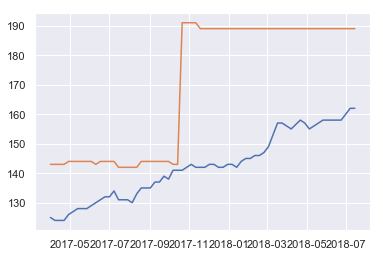

In [20]:
plotDataframe(df3)

Orange = Total Usable(Total - Faulty)<br>Blue = Used

### Keeping Only The Used Data in a New Dataframe

In [21]:
indexed_dataset = df3

In [22]:
dataset_naaaac = indexed_dataset.drop(columns = ['DSLAM_NAME','TOTAL','SPARE','FAULTY','EXCHANGE_NAME'])

In [23]:
dataset_naaaac.head()

,USED
TIME_ID,
2017-04-01,125
2017-04-08,124
2017-04-15,124
2017-04-22,124
2017-04-29,126


### Function To Test Stationarity

In [24]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determining Rolling Statistics
    movingAverage = timeseries.rolling(window=4).mean()
    movingSTD = timeseries.rolling(window=4).std()
    
    #Plot Rolling Statistics
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(movingAverage, color='red',label='Rolling Mean')
    std = plt.plot(movingSTD, color='black',label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey Fuller Test
    print('Results of Dickey Fuller Test:')
    if 'USED' in timeseries:
        dftest = adfuller(timeseries['USED'])
    else:
        dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-Value','#Lags Used','No. of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

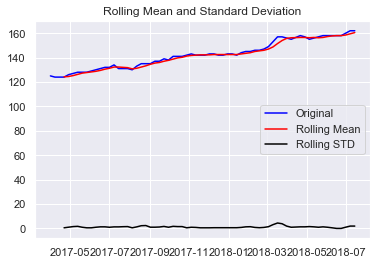

Results of Dickey Fuller Test:
Test Statistic              -0.040846
p-Value                      0.955021
#Lags Used                   0.000000
No. of Observations Used    66.000000
Critical Value (1%)         -3.533560
Critical Value (5%)         -2.906444
Critical Value (10%)        -2.590724
dtype: float64


In [25]:
test_stationarity(dataset_naaaac)

### Taking Log Transform of Data to See Trend

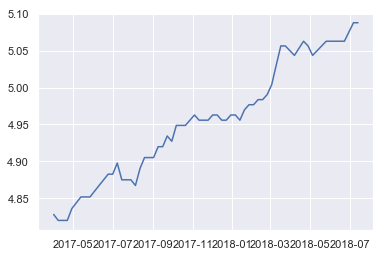

In [26]:
#Estimating Trend
dataset_naaaac_logScale = np.log(dataset_naaaac)
plt.plot(dataset_naaaac_logScale)

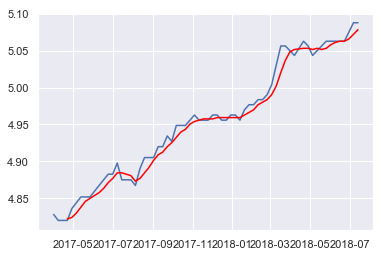

In [27]:
movingAverage = dataset_naaaac_logScale.rolling(window=4).mean()
movingSTD = dataset_naaaac_logScale.rolling(window=4).std()
plt.plot(dataset_naaaac_logScale)
plt.plot(movingAverage, color='red')

As we can see that the log transformed data is slightly better than the original data but it is still not stationary 

### Subtracting Moving Average from LogScale to achieve Stationarity

In [28]:
dataset_naaaac_logminusmovingavg = dataset_naaaac_logScale - movingAverage
dataset_naaaac_logminusmovingavg.head(10)

#Remove NaN Values
dataset_naaaac_logminusmovingavg.dropna(inplace=True)
dataset_naaaac_logminusmovingavg.head(10)

,USED
TIME_ID,
2017-04-22,-0.002008
2017-04-29,0.012000
2017-05-06,0.013929
2017-05-13,0.013835
2017-05-20,0.005898
2017-05-27,0.001961
2017-06-03,0.005837
2017-06-10,0.009683
2017-06-17,0.011554


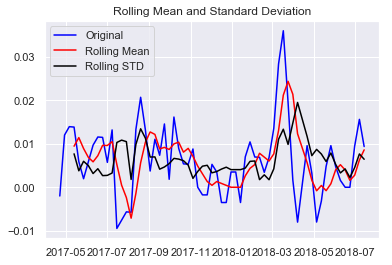

Results of Dickey Fuller Test:
Test Statistic              -4.843000
p-Value                      0.000045
#Lags Used                   1.000000
No. of Observations Used    62.000000
Critical Value (1%)         -3.540523
Critical Value (5%)         -2.909427
Critical Value (10%)        -2.592314
dtype: float64


In [29]:
test_stationarity(dataset_naaaac_logminusmovingavg)

### Taking Exponential Weighted Average to See Trend

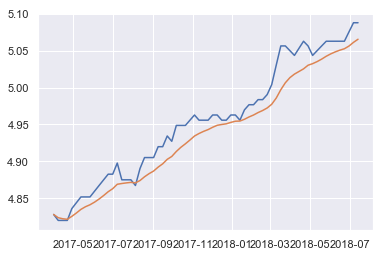

In [30]:
exponentialDecayWeightedAverage = dataset_naaaac_logScale.ewm(halflife=4, min_periods=0, adjust=True).mean()
plt.plot(dataset_naaaac_logScale)
plt.plot(exponentialDecayWeightedAverage)

### Subtracting Weighted Average from LogScale to achieve Stationarity

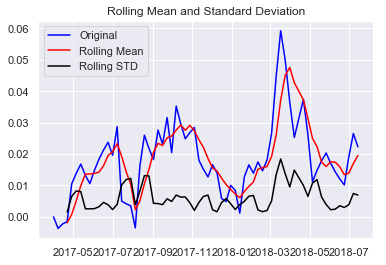

Results of Dickey Fuller Test:
Test Statistic              -3.083126
p-Value                      0.027827
#Lags Used                   0.000000
No. of Observations Used    66.000000
Critical Value (1%)         -3.533560
Critical Value (5%)         -2.906444
Critical Value (10%)        -2.590724
dtype: float64


In [31]:
dataset_naaaac_logminusweightedavg = dataset_naaaac_logScale - exponentialDecayWeightedAverage
test_stationarity(dataset_naaaac_logminusweightedavg)

### Differencing our TimeSeries

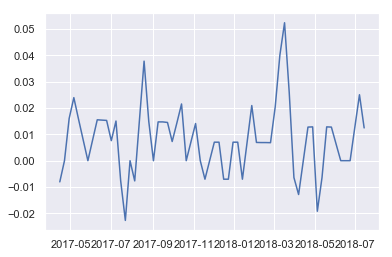

In [32]:
dataset_naaaac_diffshifting = dataset_naaaac_logScale - dataset_naaaac_logScale.shift(periods=2)
plt.plot(dataset_naaaac_diffshifting)

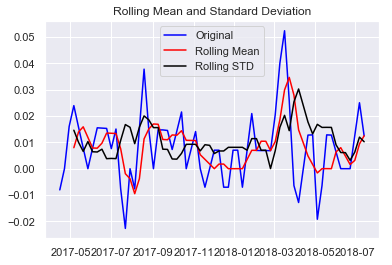

Results of Dickey Fuller Test:
Test Statistic              -4.063498
p-Value                      0.001112
#Lags Used                  11.000000
No. of Observations Used    53.000000
Critical Value (1%)         -3.560242
Critical Value (5%)         -2.917850
Critical Value (10%)        -2.596796
dtype: float64


In [33]:
dataset_naaaac_diffshifting.dropna(inplace=True)
test_stationarity(dataset_naaaac_diffshifting)

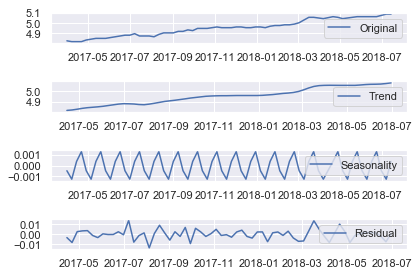

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dataset_naaaac_logScale.USED, freq=4)

trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(dataset_naaaac_logScale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonality, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()


### Checking Stationarity in Residuals

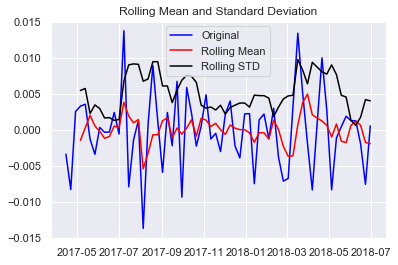

Results of Dickey Fuller Test:
Test Statistic             -8.229333e+00
p-Value                     6.123154e-13
#Lags Used                  1.000000e+00
No. of Observations Used    6.100000e+01
Critical Value (1%)        -3.542413e+00
Critical Value (5%)        -2.910236e+00
Critical Value (10%)       -2.592745e+00
dtype: float64


In [35]:
decomposed_residual = residual
decomposed_residual.dropna(inplace=True)
test_stationarity(decomposed_residual)

### Plotting ACF and PACF graphs to find P & Q values

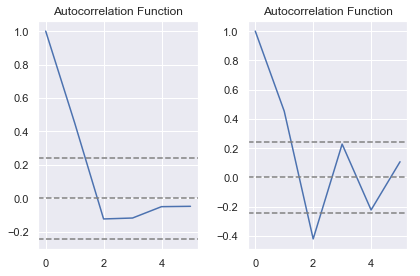

In [36]:
from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(dataset_naaaac_diffshifting, nlags=5)
lag_pacf = pacf(dataset_naaaac_diffshifting, nlags=5, method='ols')

#Plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataset_naaaac_diffshifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataset_naaaac_diffshifting)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataset_naaaac_diffshifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataset_naaaac_diffshifting)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.tight_layout()

Both the graphs cut at 0 for the first time at 1. Hence, both P & Q values will be equal to 1

### Implementing ARIMA 

C:\Users\AD0C79514\AppData\Local\Continuum\anaconda3\envs\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\AD0C79514\AppData\Local\Continuum\anaconda3\envs\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\AD0C79514\AppData\Local\Continuum\anaconda3\envs\env\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\AD0C79514\AppData\Local\Continuum\anaconda3\envs\env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood

Plotting ARIMA Model


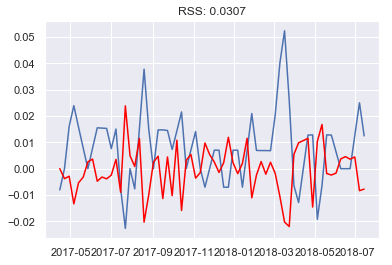

In [37]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(dataset_naaaac_logScale, order=(2,2,2))
results = model.fit()
plt.plot(dataset_naaaac_diffshifting)
plt.plot((results.fittedvalues), color='red')
plt.title('RSS: %.4f'%((results.fittedvalues-dataset_naaaac_diffshifting['USED'])**2).sum())
print('Plotting ARIMA Model')

### Making Predictions

In [38]:
dataset_naaaac_logScale.shape

(67, 1)

C:\Users\AD0C79514\AppData\Local\Continuum\anaconda3\envs\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\AD0C79514\AppData\Local\Continuum\anaconda3\envs\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\AD0C79514\AppData\Local\Continuum\anaconda3\envs\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


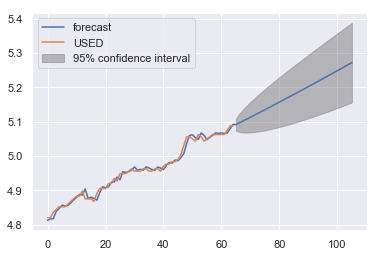

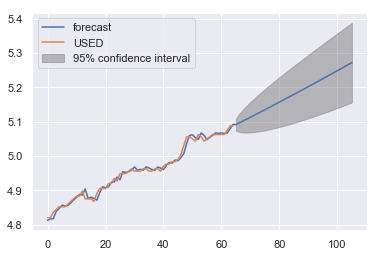

In [63]:
results.plot_predict(2,107)

### Forecasting Confidence Interval for 40 Additional Weeks

In [60]:
a = results.forecast(steps=40)[2]
a = np.exp(a)
idx = pd.date_range('2018-07-21', periods=40, freq='W-SAT')
a = pd.DataFrame(a)
a.insert(0, "TIME_ID", idx, True)
a = a.set_index(['TIME_ID'])
a.head()

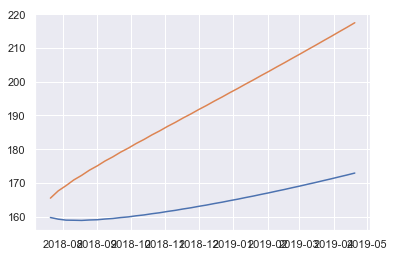

In [100]:
plt.plot(a)

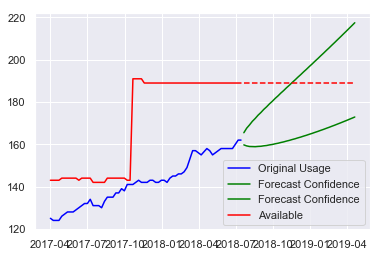

In [155]:
plt.plot(dataset_naaaac, color='blue', label='Original Usage')
plt.plot(a, color='green', label='Forecast Confidence')
b = pd.DataFrame(df3['TOTAL']-df3['FAULTY'])
plt.plot(b, color='red', label='Available')
c = pd.DataFrame(idx, columns=['TIME_ID']) 
c.insert(1, 'AVAILABLE', b[0][-1], True)
c = c.set_index(['TIME_ID'])
plt.plot(c, linestyle='dashed', color='red')
plt.legend(loc='best')

In [165]:
output = results.forecast(steps=40)

In [166]:
yhat = []

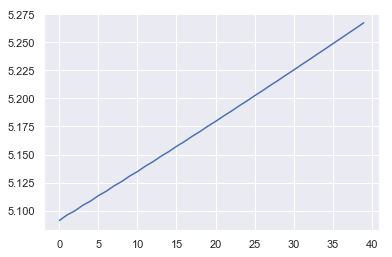

In [168]:
plt.plot(output[0])